In [1]:
import os
import torch
import pandas as pd
import numpy as np
from collections import Counter, defaultdict
from tqdm.auto import tqdm  # for notebooks
from transformers import AutoTokenizer
import matplotlib.pyplot as plt
from math import pi
tqdm.pandas()

In [2]:
HOME = os.environ.get("HOME")

In [3]:
tokenizer = AutoTokenizer.from_pretrained(
        "google/umt5-small",        
        model_max_length=256,
    )

## Load MoE inference data

In [4]:
experts = torch.load(f"{HOME}/repos/output/experts-30000.pt")
for k, v in experts.items():
    if isinstance(v, torch.Tensor):        
        experts[k] = [t for t in v]
df = pd.DataFrame(experts)

## Get top input_ids and group by Expert IDs

In [5]:
experts_by_inputs = defaultdict(list)
all_input_ids = []
def groupby_experts(row):
    filtered_experts = row["model.layers.5.mlp.router"][row["attention_mask"] == 1].tolist()
    for top2,input_id in zip(filtered_experts, row["input_ids"][row["attention_mask"] == 1].tolist()):
        for e in top2:
            all_input_ids.append(input_id)
            experts_by_inputs[e].append(input_id)
df.apply(groupby_experts,axis=1)
all_input_ids = Counter(all_input_ids)
for k,v in experts_by_inputs.items():
    experts_by_inputs[k] = Counter(v)

## Reproduce plot and table 

In [6]:
def plot_polar(experts_by_inputs,all_input_ids,tokenizer):
    expert_names = sorted(experts_by_inputs.keys())    
    N = len(expert_names)
    angles = [n / float(N) * 2 * pi for n in range(N)]
        
    ax = plt.subplot(111, polar=True)
    
    # If you want the first axis to be on top:
    # ax.set_theta_offset(pi / 2)
    # ax.set_theta_direction(-1)
        
    plt.xticks(angles, [f"E_{n}" for n in expert_names])    
    ax.yaxis.set_ticklabels([])
    
    for token_id,_ in all_input_ids.most_common(5):
        decoded = tokenizer.decode([token_id])
        values = [experts_by_inputs[n][token_id] for n in expert_names]        
        ax.plot(angles, values, linewidth=1, linestyle='solid', label=f"{decoded[0]}",)
        ax.fill(angles, values, alpha=0.1)

    # Add legend
    plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))

    # Show the graph
    plt.show()

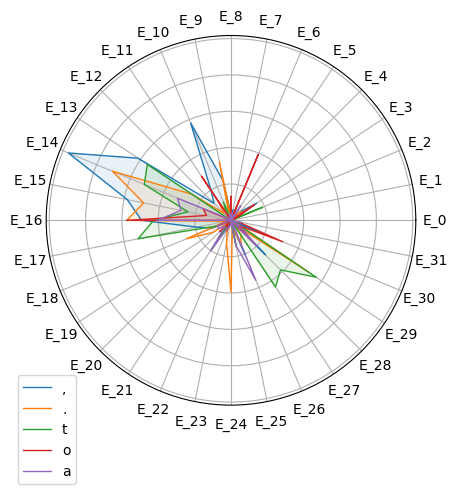

In [81]:
plot_polar(experts_by_inputs,all_input_ids,tokenizer)

In [7]:
tokens_rows = []
tokens_count = 10
expert_ids = [0,1,21,30,31]
for e in expert_ids:
    tokens = tokenizer.batch_decode([[c[0]] for c in experts_by_inputs[e].most_common(tokens_count)])    
    tokens_rows.append(tokens)
top_tokens = pd.DataFrame(tokens_rows,index=expert_ids,columns=[f"Token_{c}" for c in range(tokens_count)])
top_tokens.index.name = "Expert ID"
top_tokens

,Token_0,Token_1,Token_2,Token_3,Token_4,Token_5,Token_6,Token_7,Token_8,Token_9
Expert ID,,,,,,,,,,
0,</s>,<unk>,Texas,Real,Civil,Wh,Mc,ney,Smith,Red
1,Civil,Wh,Mc,Red,ard,Louis,nie,Britain,Boston,<unk>
21,and,the,to,<unk>,can,in,there,been,",",was
30,in,of,:,",",to,s,,this,on,ed
31,be,it,s,his,their,’,was,that,are,2
